In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import base64
import numpy as np
import seaborn as sns

from IPython.core.display import display, HTML
from sklearn.cluster import KMeans

In [2]:
plt.style.use(['dark_background'])
plt.suptitle('figure title', color='w')

Text(0.5,0.98,'figure title')

<Figure size 432x288 with 0 Axes>

In [3]:
def cluster_impute(dataframe, variables):
    region_vals = dataframe.groupby(['region_clusters'])[variables].mean()
    for i in range(0, len(np.unique(dataframe['region_clusters']))):
        dataframe.loc[dataframe.region_clusters == i, variables] = int(region_vals[i])

In [4]:
def dummy_encode(dataframe, drop_var):
    categorical_columns = dataframe.columns[dataframe.dtypes == 'object']
    for c in categorical_columns:
        dummy_set = pd.get_dummies(dataframe[c], prefix=c)
        dataframe = pd.concat([dataframe, dummy_set], axis=1)
        if drop_var:
            dataframe.drop(c, axis=1, inplace=True)
    return dataframe

### Cleaning Steps Taken:
#### Removal of rows with longitude value of 0 - UPDATE: impute with mean value instead of dropping
#### Imputation of population, construction_year, and gps_height based on the variable's cluster mean
#### Imputation of boolean variables permit and public_meeting, NaN values were set to False
#### Created year and month standalone columns
#### For the categorical variables bin anythin less than 10% of the column values into the "other" category

##### Code based on examples from https://zlatankr.github.io/posts/2017/01/23/pump-it-up

### Import Datasets

In [53]:
train_data = pd.read_csv('data/training_values.csv', header=0, sep=',')
test_data = pd.read_csv('data/test_values.csv', header=0, sep=',')

#### Print of column headers for reference

In [54]:
print(len(train_data))
print(len(train_data.columns))
print(train_data.columns)

59400
40
Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')


#### Coding for the HTML variable output
###### Code based on https://github.com/PAIR-code/facets

In [8]:
sys.path.insert(0, 'facets/facets_overview/python/')
from generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'train', 'table': train_data},
                                 {'name': 'test', 'table': test_data}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

In [9]:
HTML_TEMPLATE = """<link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/master/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

#### Add region clusters for imputation

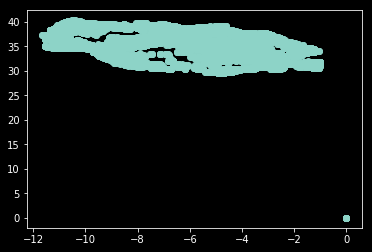

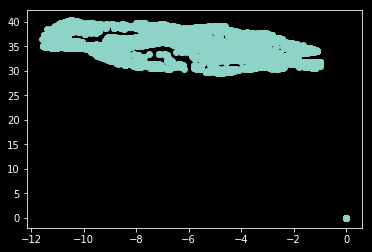

In [55]:
plt.scatter(train_data['latitude'], train_data['longitude'])
plt.show()
plt.scatter(test_data['latitude'], test_data['longitude'])
plt.show()

#### Impute 0 longitude values

In [56]:
train_data.loc[train_data['longitude'] == 0, 'latitude'] = np.mean(train_data.latitude)
train_data.loc[train_data['longitude'] == 0, 'longitude'] = np.mean(train_data.longitude)

In [57]:
test_data.loc[test_data['longitude'] == 0, 'latitude'] = np.mean(test_data.latitude)
test_data.loc[test_data['longitude'] == 0, 'longitude'] = np.mean(test_data.longitude)

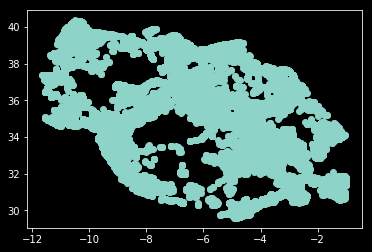

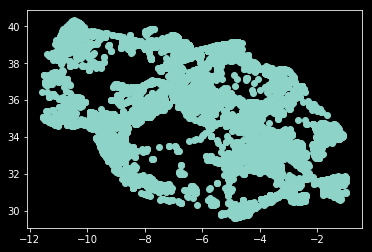

In [58]:
lat_lon_dataframe = train_data[['latitude', 'longitude']].copy()
# lat_lon_dataframe = lat_lon_dataframe[lat_lon_dataframe.ne(0).all(axis=1)]
plt.scatter(lat_lon_dataframe['latitude'], lat_lon_dataframe['longitude'])
plt.show()
lat_lon_dataframe_test = test_data[['latitude', 'longitude']].copy()
plt.scatter(lat_lon_dataframe_test['latitude'], lat_lon_dataframe_test['longitude'])
plt.show()

In [59]:
kmeans_model = KMeans(n_clusters=6, random_state=1).fit(lat_lon_dataframe)
cluster_labels = kmeans_model.predict(lat_lon_dataframe)
lat_lon_dataframe['cluster_values'] = cluster_labels

In [60]:
kmeans_test = KMeans(n_clusters=6, random_state=1).fit(lat_lon_dataframe_test)
cluster_labels_test = kmeans_model.predict(lat_lon_dataframe_test)
lat_lon_dataframe_test['cluster_values'] = cluster_labels_test

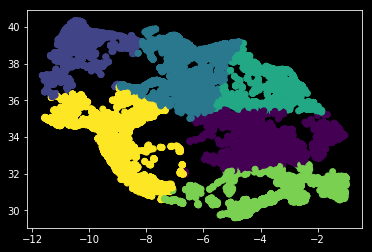

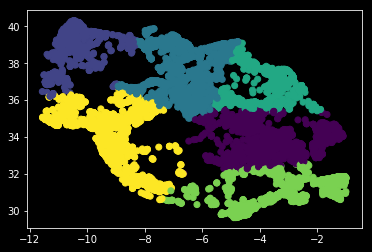

In [61]:
plt.scatter(lat_lon_dataframe['latitude'], lat_lon_dataframe['longitude'], c=lat_lon_dataframe['cluster_values'])
plt.show()
plt.scatter(lat_lon_dataframe_test['latitude'], lat_lon_dataframe_test['longitude'], c=lat_lon_dataframe_test['cluster_values'])
plt.show()

#### Remove the 0 longitude rows from the training data and add the clusters

In [62]:
# train_data = train_data[(train_data[['longitude']] != 0).all(axis=1)]
train_data['region_clusters'] = cluster_labels
test_data['region_clusters'] = cluster_labels_test

#### Impute population, construction_year, and gps_height

In [63]:
train_data.astype(bool).sum(axis=0)

id                       59399
amount_tsh               17761
date_recorded            59400
funder                   59400
gps_height               38962
installer                59400
longitude                59400
latitude                 59400
wpt_name                 59400
num_private                757
basin                    59400
subvillage               59400
region                   59400
region_code              59400
district_code            59377
lga                      59400
ward                     59400
population               38019
public_meeting           54345
recorded_by              59400
scheme_management        59400
scheme_name              59400
permit                   41908
construction_year        38691
extraction_type          59400
extraction_type_group    59400
extraction_type_class    59400
management               59400
management_group         59400
payment                  59400
payment_type             59400
water_quality            59400
quality_

In [64]:
cluster_impute(train_data, 'population')
cluster_impute(train_data, 'construction_year')
cluster_impute(train_data, 'gps_height')

In [65]:
cluster_impute(test_data, 'population')
cluster_impute(test_data, 'construction_year')
cluster_impute(test_data, 'gps_height')

In [66]:
train_data.astype(bool).sum(axis=0)

id                       59399
amount_tsh               17761
date_recorded            59400
funder                   59400
gps_height               59400
installer                59400
longitude                59400
latitude                 59400
wpt_name                 59400
num_private                757
basin                    59400
subvillage               59400
region                   59400
region_code              59400
district_code            59377
lga                      59400
ward                     59400
population               59400
public_meeting           54345
recorded_by              59400
scheme_management        59400
scheme_name              59400
permit                   41908
construction_year        59400
extraction_type          59400
extraction_type_group    59400
extraction_type_class    59400
management               59400
management_group         59400
payment                  59400
payment_type             59400
water_quality            59400
quality_

#### Date formatting

In [67]:
train_data['date_recorded'] = pd.to_datetime(train_data['date_recorded'])
test_data['date_recorded'] = pd.to_datetime(test_data['date_recorded'])

In [68]:
print(train_data['date_recorded'].head())

0   2011-03-14
1   2013-03-06
2   2013-02-25
3   2013-01-28
4   2011-07-13
Name: date_recorded, dtype: datetime64[ns]


In [69]:
train_data['year'], train_data['month'] = train_data['date_recorded'].dt.year, train_data['date_recorded'].dt.month
test_data['year'], test_data['month'] = test_data['date_recorded'].dt.year, test_data['date_recorded'].dt.month

In [70]:
print(train_data['year'].head())

0    2011
1    2013
2    2013
3    2013
4    2011
Name: year, dtype: int64


In [71]:
print(train_data['month'].head())

0    3
1    3
2    2
3    1
4    7
Name: month, dtype: int64


#### Impute True/False Variables (permit and public_meeting)

In [72]:
print(sum(pd.isna(train_data.permit)))
print(sum(pd.isna(train_data.public_meeting)))

3056
3334


In [73]:
train_data['permit'] = train_data['permit'].fillna(False)
train_data['public_meeting'] = train_data['public_meeting'].fillna(False)
test_data['permit'] = test_data['permit'].fillna(False)
test_data['public_meeting'] = test_data['public_meeting'].fillna(False)

In [74]:
print(sum(pd.isna(train_data.permit)))
print(sum(pd.isna(train_data.public_meeting)))

0
0


#### Save first version of the data for variable importance

In [75]:
train_data.to_csv("data/train_data_var_importance.csv", sep=",", header=True)
test_data.to_csv("data/test_data_var_importance.csv", sep=",", header=True)

#### Remove duplicat variables

drop_list = ['id', 'quantity_group', 'wpt_name', 'subvillage', 'ward', 'extraction_type', 'extraction_type_group', 'scheme_name', 'payment', 'payment_type', 'scheme_management', 'source', 'basin', 
             'management', 'source_type', 'waterpoint_type_group', 'month', 'water_quality', 'quality_group', 'region_code', 'district_code', 'management_group', 'permit', 'public_meeting', 
             'source_class', 'region_clusters', 'population', 'construction_year', 'gps_height', 'year', 'amount_tsh', 'num_private', 'recorded_by']

In [76]:
drop_list = ['extraction_type_group', 'extraction_type_class', 'payment_type', 'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']

In [77]:
train_data.drop(drop_list, axis=1, inplace=True)
test_data.drop(drop_list, axis=1, inplace=True)

In [78]:
print(train_data.columns)
print(test_data.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'management', 'management_group', 'payment',
       'water_quality', 'quantity', 'source', 'region_clusters', 'year',
       'month'],
      dtype='object')
Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'management', 'management_group', 'payment',
       'water_quality', 'quantity', 

In [79]:
print(train_data.describe(include='all'))

                  id     amount_tsh        date_recorded  \
count   59400.000000   59400.000000                59400   
unique           NaN            NaN                  356   
top              NaN            NaN  2011-03-15 00:00:00   
freq             NaN            NaN                  572   
first            NaN            NaN  2002-10-14 00:00:00   
last             NaN            NaN  2013-12-03 00:00:00   
mean    37115.131768     317.650385                  NaN   
std     21453.128371    2997.574558                  NaN   
min         0.000000       0.000000                  NaN   
25%     18519.750000       0.000000                  NaN   
50%     37061.500000       0.000000                  NaN   
75%     55656.500000      20.000000                  NaN   
max     74247.000000  350000.000000                  NaN   

                        funder    gps_height installer     longitude  \
count                    55765  59400.000000     55745  59400.000000   
unique         

#### Spot check categorical variables

In [37]:
tmp1 = pd.value_counts(train_data['water_quality'])
tmp2 = (tmp1/tmp1.sum() * 100)
print(tmp2)

soft                  85.552189
salty                  8.175084
unknown                3.158249
milky                  1.353535
coloured               0.824916
salty abandoned        0.570707
fluoride               0.336700
fluoride abandoned     0.028620
Name: water_quality, dtype: float64


#### Summarize low frequency categorical variables
##### Any categorical variable value that makes up less than 3% of the unique vales for the variable will be binned into the "other" category

##### Example based on https://stackoverflow.com/questions/47418299/python-combining-low-frequency-factors-category-counts

In [80]:
categorical_columns = train_data.columns[train_data.dtypes == 'object']
for c in categorical_columns:
    series = pd.value_counts(train_data[c])
    mask = (series/series.sum() * 100).lt(3)
    train_data[c] = np.where(train_data[c].isin(series[mask].index), 'other', train_data[c])
#     print((series/series.sum() * 100).lt(10))

In [81]:
categorical_columns_test = test_data.columns[test_data.dtypes == 'object']
for ct in categorical_columns:
    series_test = pd.value_counts(test_data[ct])
    mask_test = (series_test/series_test.sum() * 100).lt(3)
    test_data[ct] = np.where(test_data[ct].isin(series_test[mask_test].index), 'other', test_data[ct])

In [82]:
for i in train_data.columns[train_data.dtypes == 'object']:
    print(pd.value_counts(train_data[i]))

other                     41365
Government Of Tanzania     9084
Danida                     3114
Hesawa                     2202
Name: funder, dtype: int64
other         36518
DWE           17402
Government     1825
Name: installer, dtype: int64
other    55837
none      3563
Name: wpt_name, dtype: int64
Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64
other    59029
Name: subvillage, dtype: int64
other          5664
Iringa         5294
Shinyanga      4982
Mbeya          4639
Kilimanjaro    4379
Morogoro       4006
Arusha         3350
Kagera         3316
Mwanza         3102
Kigoma         2816
Ruvuma         2640
Pwani          2635
Tanga          2547
Dodoma         2201
Singida        2093
Mara           1969
Tabora 

#### For funder and installer if there are any blank values add them as 'other'

In [83]:
train_data['funder'].fillna('other', inplace=True)
train_data['installer'].fillna('other', inplace=True)
test_data['funder'].fillna('other', inplace=True)
test_data['installer'].fillna('other', inplace=True)

In [84]:
print(train_data.describe(include='all'))

                  id     amount_tsh        date_recorded funder    gps_height  \
count   59400.000000   59400.000000                59400  59400  59400.000000   
unique           NaN            NaN                  356      4           NaN   
top              NaN            NaN  2011-03-15 00:00:00  other           NaN   
freq             NaN            NaN                  572  45000           NaN   
first            NaN            NaN  2002-10-14 00:00:00    NaN           NaN   
last             NaN            NaN  2013-12-03 00:00:00    NaN           NaN   
mean    37115.131768     317.650385                  NaN    NaN    667.976347   
std     21453.128371    2997.574558                  NaN    NaN    341.938358   
min         0.000000       0.000000                  NaN    NaN    233.000000   
25%     18519.750000       0.000000                  NaN    NaN    521.000000   
50%     37061.500000       0.000000                  NaN    NaN    535.000000   
75%     55656.500000      20

#### Dummy encode the categorical variables

In [85]:
train_data = dummy_encode(train_data, True)
test_data = dummy_encode(test_data, True)

In [86]:
print(len(train_data.columns))
print(train_data.columns)
print(len(test_data.columns))
print(test_data.columns)

103
Index(['id', 'amount_tsh', 'date_recorded', 'gps_height', 'longitude',
       'latitude', 'num_private', 'region_code', 'district_code', 'population',
       ...
       'quantity_enough', 'quantity_insufficient', 'quantity_other',
       'quantity_seasonal', 'source_machine dbh', 'source_other',
       'source_rainwater harvesting', 'source_river', 'source_shallow well',
       'source_spring'],
      dtype='object', length=103)
103
Index(['id', 'amount_tsh', 'date_recorded', 'gps_height', 'longitude',
       'latitude', 'num_private', 'region_code', 'district_code', 'population',
       ...
       'quantity_enough', 'quantity_insufficient', 'quantity_other',
       'quantity_seasonal', 'source_machine dbh', 'source_other',
       'source_rainwater harvesting', 'source_river', 'source_shallow well',
       'source_spring'],
      dtype='object', length=103)


In [87]:
print(train_data['ward_other'].head())
print(train_data['recorded_by_GeoData Consultants Ltd'].head())

0    1
1    1
2    1
3    1
4    1
Name: ward_other, dtype: uint8
0    1
1    1
2    1
3    1
4    1
Name: recorded_by_GeoData Consultants Ltd, dtype: uint8


In [88]:
variable_correlation = train_data.corr()

In [89]:
print(np.abs(variable_correlation) > .5)

                                  id  amount_tsh  gps_height  longitude  \
id                              True       False       False      False   
amount_tsh                     False        True       False      False   
gps_height                     False       False        True      False   
longitude                      False       False       False       True   
latitude                       False       False       False      False   
num_private                    False       False       False      False   
region_code                    False       False       False      False   
district_code                  False       False       False      False   
population                     False       False        True      False   
public_meeting                 False       False       False      False   
permit                         False       False       False      False   
construction_year              False       False       False       True   
region_clusters          

#### Check variable correlation

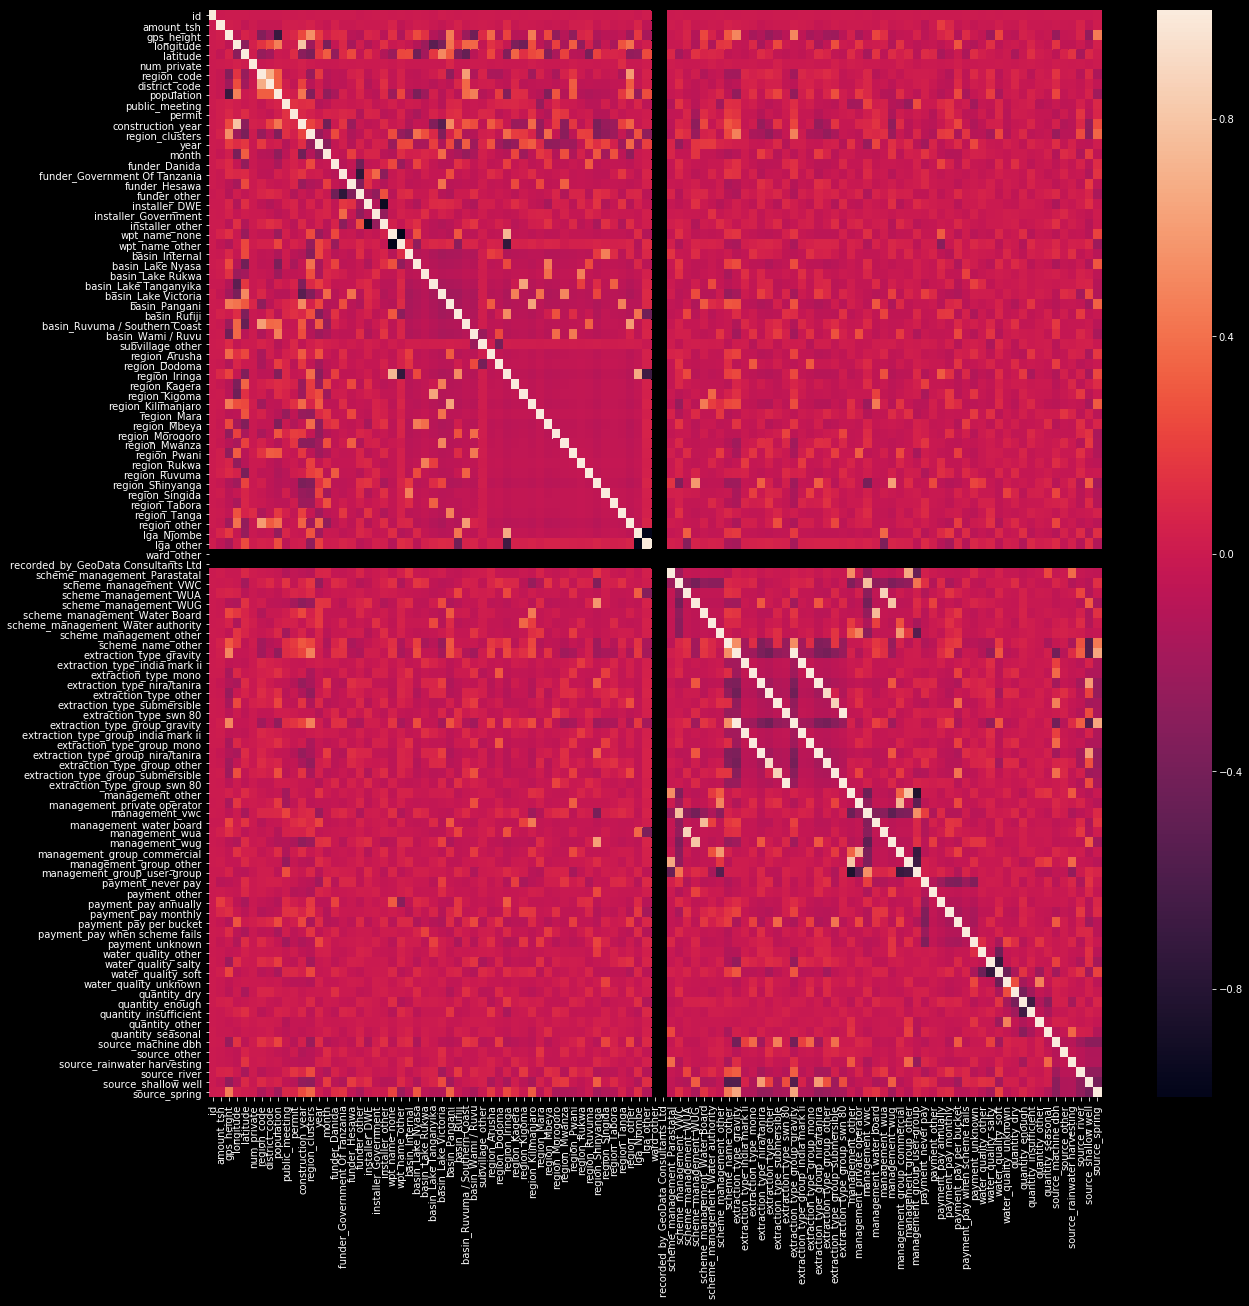

In [49]:
plt.subplots(figsize=(20,20))
var_cor = sns.heatmap(variable_correlation, xticklabels=variable_correlation.columns, yticklabels=variable_correlation.columns, annot=False)

In [42]:
var_cor.figure.savefig('images/variable_correlations.png')

In [50]:
variable_correlation.to_csv('data/variable_correlations.csv', sep=",")

#### Report for percentage of other

In [90]:
train_data.to_csv("data/train_dataframe_full.csv", sep=",", header=True)
test_data.to_csv("data/test_dataframe_full.csv", sep=",", header=True)